<a href="https://colab.research.google.com/github/nikolimaj/text_mining/blob/main/Ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading our data

For the following exercise we will use the word count matrix representation and only use a small subset of our data since we will implement a naiveBayes classifier - which is a "lazy learner" and so predictions will be rather slow.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import itertools
import kagglehub

### Download data

In [3]:
path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/shanegerami/ai-vs-human-text/versions/1


### Reading and cleaning data

In [44]:
import re

def clean(text: str, keep_sentences: bool = True) -> str:
    if keep_sentences:
        return re.sub(r"[^a-zA-Z\.\?\!\s]+", "", text)
    return re.sub(r"[^a-zA-Z\s]+", "", text)

In [45]:
data = pd.read_csv(path + "/AI_Human.csv")

# only use small subset of data
data = data.sample(frac = 0.01)

data["text"] = [clean(row["text"]) for i, row in data.iterrows()]

### Splitting data into a training dataset and a test dataset

In [46]:
train, test = train_test_split(data, test_size = 0.35)
print(train.shape)
print(test.shape)
train.head()

(3166, 2)
(1706, 2)


,text,generated
394508,IV the past century cars have become av essent...,1.0
457361,Not too long ago I got into a disagreement wit...,0.0
153954,Conserving your energy its an important matter...,0.0
286826,Some schools are now offering distance learnin...,1.0
421471,When I first entered college I faced an obstac...,1.0


### Creating the word count matrices

Notice that we will not fit_transform the test data but apply the same transformation that we use for the training data.

In [47]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
text_train = train["text"]
y_train = train["generated"]
text_test = test["text"]
y_test = test["generated"]

from nltk.corpus import stopwords as nltkStopwords
from sklearn.feature_extraction.text import CountVectorizer

stopwords_en = list(nltkStopwords.words("english"))
count_vectorizer = CountVectorizer(strip_accents = "unicode",
                                   stop_words = stopwords_en)

X_train = count_vectorizer.fit_transform(text_train)
X_test = count_vectorizer.transform(text_test)
counts_features_names = count_vectorizer.get_feature_names_out()
print(X_train.shape)
print(X_test.shape)
print(counts_features_names.shape)

counts_train = pd.DataFrame(X_train.A, columns = counts_features_names)
counts_test = pd.DataFrame(X_test.A, columns = counts_features_names)

(3166, 22043)
(1706, 22043)
(22043,)


### Use the following function to plot confusion matrices of the predictions

In [49]:
def plot_confusion_matrix(cm, classes, normalize = False, title = "Confusion matrix", cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim(len(cm) - 0.5, -0.5)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    return cm

# **Classification**

In [50]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(counts_train, y_train)

MultinomialNB()

### Evaluate your implementation on the training data...

In [51]:
pred_train = NB.predict(counts_train)

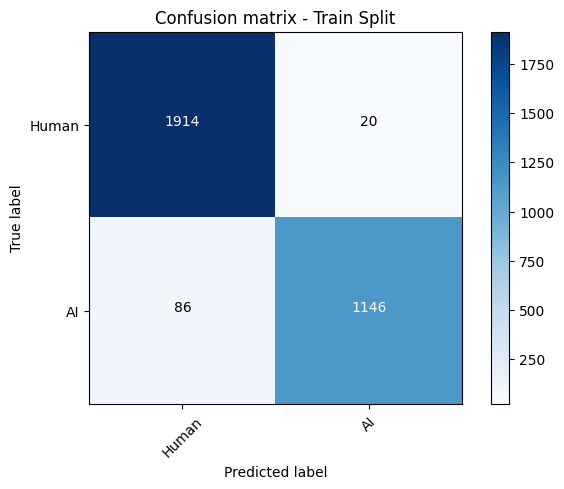

In [52]:
conf = confusion_matrix(y_train, pred_train)

plt.figure()
plot = plot_confusion_matrix(conf, classes = ["Human", "AI"], title = "Confusion matrix - Train Split")
plt.show()

In [53]:
print("Train Accuracy: ", accuracy_score(y_train, pred_train))

Train Accuracy:  0.9665192672141504


### ...and on the test data

In [54]:
pred_test = NB.predict(counts_test)

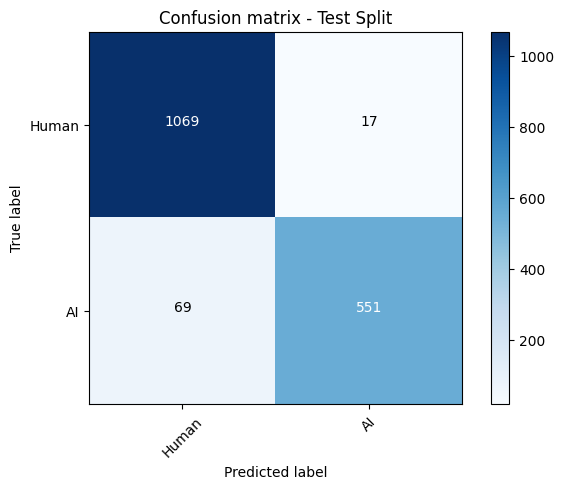

In [55]:
conf = confusion_matrix(y_test, pred_test)

plt.figure()
plot = plot_confusion_matrix(conf, classes = ["Human", "AI"], title = "Confusion matrix - Test Split")
plt.show()

In [56]:
print("Test Accuracy: ", accuracy_score(y_test, pred_test))

Test Accuracy:  0.9495896834701055


### What can you observe?

Does it work well? What does accuracy in this context mean given that we have four balanced classes (and we assume that our sample is truly random)? What could be pitfalls why the classifier doesn't work well?